# Set up

## Package Loading

In [2]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
! pip install imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
import mlxtend
import matplotlib.pyplot as plt
import time
import joblib
import gzip
import json
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Up paths

In [3]:
# Parent paths
parent_path = '/content/drive/My Drive/'


#Specific paths
path_hyperparameters_nb = parent_path+"Web_Mining_Project/2labels/classifier_parameters/best_parameters/nb.csv"
path_hyperparameters_knn = parent_path+"Web_Mining_Project/2labels/classifier_parameters/best_parameters/knn.csv"
path_hyperparameters_rf = parent_path+"Web_Mining_Project/2labels/classifier_parameters/best_parameters/rf.csv"
path_hyperparameters_svm = parent_path+"Web_Mining_Project/2labels/classifier_parameters/best_parameters/svm.csv"
path_hyperparameters_lr = parent_path+"Web_Mining_Project/with_pre/classifier_parameters/best_parameters/lr.csv"

path_best_parameters_nb = parent_path+"Web_Mining_Project/2labels/classifier_parameters/nb.pkl"
path_best_parameters_knn = parent_path+"Web_Mining_Project/2labels/classifier_parameters/knn.pkl"
path_best_parameters_rf = parent_path+"Web_Mining_Project/2labels/classifier_parameters/rf.pkl"
path_best_parameters_svm = parent_path+"Web_Mining_Project/2labels/classifier_parameters/svm.pkl"
path_best_parameters_lr = parent_path+"Web_Mining_Project/2labels/classifier_parameters/lr.pkl"
#dataset paths 
path_complete_dataset = parent_path + "Web_Mining_Project/data/complete_dataset.csv"
path_shortend_dataset = parent_path + "Web_Mining_Project/data/shortend10000_dataset.csv"
path_shortend10000_preprocessed = parent_path + "Web_Mining_Project/data/shortend10000_dataset_preprocessed.csv"
path_shortend50000_preprocessed = parent_path + "Web_Mining_Project/data/shortend50000_dataset_preprocessed.csv"

## Set Up Functions

In [4]:
# function for evaluation(confusion matrix)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# function for sentiment label creating 
def create_labels_from_rating(score):
  score = int(score)
  if score <= 2:
    return 0 #negative
  elif score == 3:
    return 1 #neutral
  else:
    return 2 #positive
  
# function to bin vote column 
def bin_vote(vote):
  vote = int(vote)

  if vote < 2:
    return 0
  elif vote >= 2 and vote <= 6:
    return 1 
  else:
    return 2

# Data Download and Exploration

In [5]:
# create dataframe 
df = pd.read_csv(path_shortend_dataset)
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(10000, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


overall           False
verified          False
reviewTime        False
reviewerID        False
asin              False
reviewerName      False
reviewText        False
summary            True
unixReviewTime    False
vote               True
style              True
image              True
dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         10000 non-null  float64
 1   verified        10000 non-null  bool   
 2   reviewTime      10000 non-null  object 
 3   reviewerID      10000 non-null  object 
 4   asin            10000 non-null  object 
 5   reviewerName    10000 non-null  object 
 6   reviewText      10000 non-null  object 
 7   summary         9999 non-null   object 
 8   unixReviewTime  10000 non-null  int64  
 9   vote            2716 non-null   float64
 10  style           3784 non-null   object 
 11  i

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


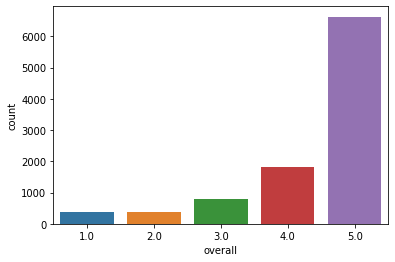

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning




count    10000.000000
mean         1.743100
std          7.031931
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        281.000000
Name: vote, dtype: float64


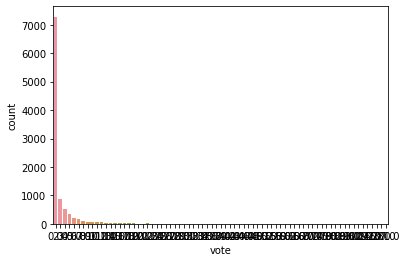

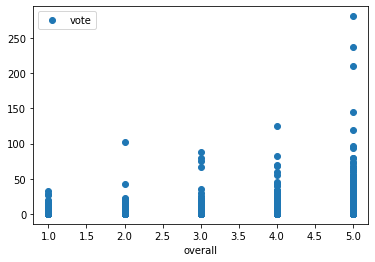

In [6]:
# General Information and Null values
print(df.isnull().any())
print()
df.info()
print()
print(df.dtypes)
print()
print(df.overall.describe())
print()
# plot the score & check for the distribution of the star ratings 
sns.countplot(df.overall)
plt.show()
print()
# plot distribution of vote column
df['vote'] = df['vote'].fillna(0)
sns.countplot(df.vote)
print()
print(df.vote.describe())
# plot vote depending on overall
df.plot(x='overall', y='vote', style='o')

# Data Preprocessing and further Exploration

## Label creation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


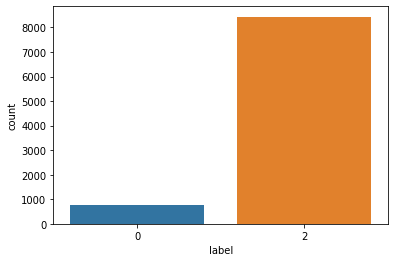

In [7]:
df['label'] = df['overall'].apply(create_labels_from_rating)
# plot the score & check for the distribution of the star ratings 
# drop labels 1 
df = df[df.label != 1]
sns.countplot(df.label)
plt.show()

## Feature Generation and Selection

In [8]:
# Frequency encoding using value_counts function ------ generated features not used 
reviewerID_freq = df['reviewerID'].value_counts()
# Mapping the encoded values with original data
df['reviewer_amount_of_reviews'] = df['reviewerID'].apply(lambda x : reviewerID_freq[x])
# detecting mean of ratings score per user
df['reviewer_mean_score'] = df.groupby(['reviewerID'])['overall'].transform(lambda x: x.mean())
df.drop(columns=['overall','reviewerID', 'asin', 'reviewerName', 'reviewTime','style', 'image'], inplace=True)
print(df.shape)
print(df.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(9192, 8)
Index(['verified', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'label',
       'reviewer_amount_of_reviews', 'reviewer_mean_score'],
      dtype='object')


In [9]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]
df.dropna(inplace=True)
print(df.shape)
print(df.head())

(9191, 8)
   verified                                         reviewText  \
0      True  This game is a bit hard to get the hang of, bu...   
1     False  I played it a while but it was alright. The st...   
3      True  found the game a bit too complicated, not what...   
4      True  great game, I love it and have played it since...   
5      True  i liked a lot some time that i haven't play a ...   

                                       summary  unixReviewTime  vote  label  \
0                  but when you do it's great.      1445040000     0      2   
1  But in spite of that it was fun, I liked it      1437955200     0      2   
3                                    Two Stars      1424390400     0      0   
4                               love this game      1419465600     0      2   
5                                    Anno 2070      1415836800     0      2   

   reviewer_amount_of_reviews  reviewer_mean_score  
0                           1                  5.0  
1           

## Tokenization 

In [10]:
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]

#tokenize and use stemming 
#stemmer = PorterStemmer()
#print(df.head())
#df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
#df['summary'] = df['summary'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
#print(df.head())

# tokenize and remove stopwords 
stop = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.dropna(inplace=True)
print(df.head())
print(df.shape)

   verified                                         reviewText  \
0      True             This game bit hard get hang of, great.   
1     False  I played alright. The steam bit trouble. The m...   
3      True  found game bit complicated, I expected played ...   
4      True            great game, I love played since arrived   
5      True  liked lot time play wonderfull game simply fun...   

                  summary  unixReviewTime  vote  label  \
0                  great.      1445040000     0      2   
1  But spite fun, I liked      1437955200     0      2   
3               Two Stars      1424390400     0      0   
4               love game      1419465600     0      2   
5               Anno 2070      1415836800     0      2   

   reviewer_amount_of_reviews  reviewer_mean_score  
0                           1                  5.0  
1                           1                  4.0  
3                           1                  2.0  
4                           2             

# Train Test Split and shortening 

In [11]:
df.dropna(inplace=True)
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))] 
df = df[df['summary'].apply(lambda x: isinstance(x, str))]

In [12]:
# split into train and test set
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])

y_train = x_train['label']
y_test = x_test['label']

print (f"y_train: {y_train.shape}/ x_train: {x_train.shape}")
print (f"y_test: {y_test.shape}/ x_test: {x_test.shape}")
print(x_train.head())

y_train: (7352,)/ x_train: (7352, 8)
y_test: (1839,)/ x_test: (1839, 8)
      verified                                         reviewText  \
1262     False  Fans dedicated single-player "first person sho...   
3306     False  Final Fantasy 7 best final fantasy game fun ad...   
7254     False  It's good game easily beaten enough common sen...   
3421      True              Plays looks great! Thanks very, much!   
3068     False  Graphics: 9/10 - Nothing ugly Ape Escape, look...   

                                                summary  unixReviewTime  vote  \
1262  (XP User) A series unfortunate incidents...luc...      1119398400     1   
3306                                 Best Final Fantasy      1088985600     0   
7254                                         Good Game.      1393545600     1   
3421                                         Five Stars      1424217600     0   
3068                                    Fantastical fun       995673600     0   

      label  reviewer_amou

# Model Training

## Set Up Pipeline

In [13]:

# define transforms
vectorizer = TfidfVectorizer()

# define sampling
sampling = RandomOverSampler(random_state=452)

# define the scoring function
f1 = make_scorer(f1_score, average='weighted')

# set up cross validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# dataset preparation
x_train.drop(columns = ['label'], inplace= True)
x_test.drop(columns = ['label'], inplace= True)
x_train = x_train['reviewText']
x_test = x_test['reviewText']
print(x_train.shape)
print(y_train.shape)
print(x_train.head(5))




(7352,)
(7352,)
1262    Fans dedicated single-player "first person sho...
3306    Final Fantasy 7 best final fantasy game fun ad...
7254    It's good game easily beaten enough common sen...
3421                Plays looks great! Thanks very, much!
3068    Graphics: 9/10 - Nothing ugly Ape Escape, look...
Name: reviewText, dtype: object


## Naïve Bayes

In [14]:

# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of possible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer),('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', MultinomialNB())])
Fitting 5 folds for each of 144 candidates, totalling 720 fits
--- 377.03494453430176 seconds ---
Multinomial NBClassifier: 90.78541770801394% F1-score for class 'label' with parameters {'estimator__alpha': 0.01, 'vectorizer__max_df': 0.75, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/Web_Mining_Project/2labels/classifier_parameters/nb.pkl']

              precision    recall  f1-score   support

           0       0.48      0.49      0.49       151
           2       0.95      0.95      0.95      1688

    accuracy                           0.91      1839
   macro avg       0.72      0.72      0.72      1839
weighted avg       0.92      0.91      0.92      1839



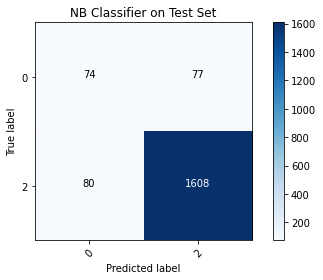

In [15]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))

## Knn

In [16]:
# Optimize parameters for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()

vectorizer = TfidfVectorizer(max_df=0.25, norm=None, smooth_idf=False)

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_neighbors': [5, 10, 15, 20, 25],
    'estimator__weights': ['uniform','distance'],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
       }

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("KNN : {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_knn, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_knn, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.25, norm=None, smooth_idf=False)),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', KNeighborsClassifier())])
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


--- 218.15404152870178 seconds ---
KNN : 87.16823863240613% F1-score for class 'label' with parameters {'estimator__algorithm': 'auto', 'estimator__n_neighbors': 5, 'estimator__weights': 'distance'}


['/content/drive/My Drive/Web_Mining_Project/2labels/classifier_parameters/knn.pkl']

              precision    recall  f1-score   support

           0       0.22      0.25      0.23       151
           2       0.93      0.92      0.93      1688

    accuracy                           0.87      1839
   macro avg       0.57      0.58      0.58      1839
weighted avg       0.87      0.87      0.87      1839



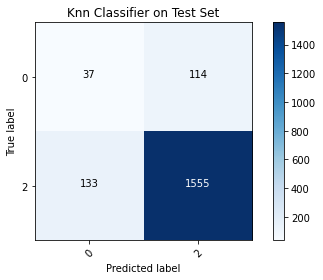

In [17]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Knn Classifier on Test Set")
print(classification_report(y_test, prediction))

## Random Forest

In [18]:
# Optimize parameters for Random Forest
estimator = RandomForestClassifier( random_state=42)

vectorizer = TfidfVectorizer(max_df=0.25, smooth_idf=True)

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_estimators': [100, 300, 500],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=10)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Random Forest Classifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_rf, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_rf, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.25)),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', RandomForestClassifier(random_state=42))])
Fitting 5 folds for each of 81 candidates, totalling 405 fits
--- 1143.8704144954681 seconds ---
Random Forest Classifier: 92.88397733249833% F1-score for class 'label' with parameters {'estimator__max_depth': 25, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 100, 'estimator__n_estimators': 300}


['/content/drive/My Drive/Web_Mining_Project/2labels/classifier_parameters/rf.pkl']

              precision    recall  f1-score   support

           0       0.59      0.52      0.56       151
           2       0.96      0.97      0.96      1688

    accuracy                           0.93      1839
   macro avg       0.78      0.75      0.76      1839
weighted avg       0.93      0.93      0.93      1839



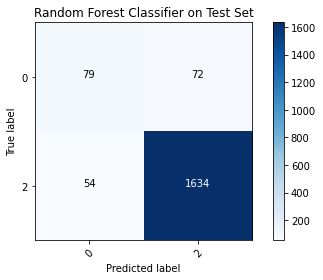

In [19]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Random Forest Classifier on Test Set")
print(classification_report(y_test, prediction))

## SVM

In [20]:
# Optimize parameters for LSVM Classifier
estimator = LinearSVC(max_iter=5000, random_state=42, dual = True)

vectorizer = TfidfVectorizer()

# Define grid of posible hyperparamters values 
parameters = {
    #'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    #'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("LSVM Classifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_svm, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_svm, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', LinearSVC(max_iter=5000, random_state=42))])
Fitting 5 folds for each of 48 candidates, totalling 240 fits
--- 730.9117558002472 seconds ---
LSVM Classifier: 93.46478838710608% F1-score for class 'label' with parameters {'estimator__C': 1, 'estimator__loss': 'squared_hinge', 'estimator__tol': 0.01}


['/content/drive/My Drive/Web_Mining_Project/2labels/classifier_parameters/svm.pkl']

              precision    recall  f1-score   support

           0       0.62      0.50      0.56       151
           2       0.96      0.97      0.96      1688

    accuracy                           0.93      1839
   macro avg       0.79      0.74      0.76      1839
weighted avg       0.93      0.93      0.93      1839



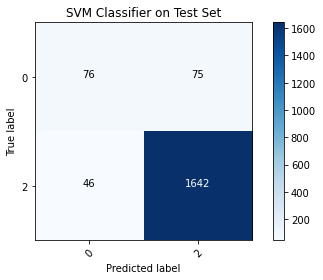

In [21]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "SVM Classifier on Test Set")
print(classification_report(y_test, prediction))

## Logistic Regression

In [22]:
# Optimize parameters for Logistic Regression
estimator = LogisticRegression()

vectorizer = TfidfVectorizer(max_df=0.5, smooth_idf=True)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    #'vectorizer__norm': ('l1', 'l2', None),
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'estimator__C': [100, 10, 1.0, 0.1, 0.01]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Logistic Regression Classifier: {}% F1-score for class 'label' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_lr, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_lr, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5)),
                ('balancing', RandomOverSampler(random_state=452)),
                ('estimator', LogisticRegression())])
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
--- 840.899979352951 seconds ---
Logistic Regression Classifier: 93.57343837336293% F1-score for class 'label' with parameters {'estimator__C': 10, 'estimator__solver': 'saga', 'vectorizer__max_df': 0.5, 'vectorizer__smooth_idf': False}


['/content/drive/My Drive/Web_Mining_Project/2labels/classifier_parameters/lr.pkl']

              precision    recall  f1-score   support

           0       0.61      0.54      0.58       151
           2       0.96      0.97      0.96      1688

    accuracy                           0.93      1839
   macro avg       0.79      0.76      0.77      1839
weighted avg       0.93      0.93      0.93      1839



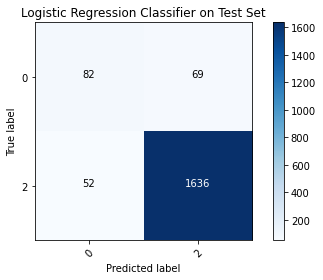

In [23]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Logistic Regression Classifier on Test Set")
print(classification_report(y_test, prediction))